In [1]:
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")
from scipy.interpolate import UnivariateSpline

In [2]:
from nltk import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
from ast import literal_eval

In [3]:
emnlp = False  # Set to True if you want to see the result using the Xie et al., 2019 framework

In [4]:
if emnlp:
    files = pickle.load(open("./data/emnlp_scores_coha.p", "rb"))
    files.keys()
    df1 = files["moral_relevance"]
    df1["property"] = ["previous_link"] * len(df1)

    df2 = files["moral_polarity"]
    df2["property"] = ["polarity"] * len(df2)

    ts_df = pd.concat((df1, df2), ignore_index=True)
    ts_df["words"] = ts_df["word"]
    ts_df.drop(["word", "vector"], axis=1, inplace=True)
    ts_df["outputs_z"] = ts_df["outputs"].apply(lambda p: np.log(p / (1 - p)))
    ts_df = ts_df.loc[ts_df.year >= 1850].reset_index(drop=True)

else:  # Loading time series data for COHA
    ts_df = pd.read_csv("./data/SWOW_prediction/eval/time_series/ts_df.csv")

    ts_df = (
        ts_df.groupby(["words", "year", "property"])[["outputs_z", "count"]]
        .mean()
        .reset_index()
    )
    ts_df = ts_df.loc[ts_df["count"] >= 50]

In [5]:
# Download datset (HCED Data v2.csv) from https://journals.sagepub.com/doi/10.1177/00220027221119085


# Loading international conflict dataset

df = pd.read_csv("./data/HCED Data v2.csv", encoding="latin-1")
df.sample(5)

,Unnamed: 0,ID,Country,Latitude,Longitude,Page,Battle,Year,Participants,War,...,Loser,Participant 1,Participant 2,Lehmann Zhukov Scale,Theatre,Polygon,Massacre,Alternative Sources Consulted,Infered Scale,Minor
9631,9062.0,Macassar1660,Indonesia,-4.417019,118.5386213,612,Macassar,1660,"['Dutch', 'Dutch', 'Portuguese', 'Fort Panakku...",Dutch Wars in the East Indies,...,Macassar,NaN,NaN,2.0,Sea,NaN,No,NaN,1,NaN
2520,2417.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15089,14210.0,South Georgia1982,United Kingdom,-54.281505,-36.5110999,962,South Georgia,1982,"['South Georgia', 'British', 'Argentine', 'Bri...",Falklands War,...,Argentina,NaN,NaN,1.0,Land,NaN,No,"Clodfelter, Warfare and Armed Conflict, p651",NaN,1.0
5641,5354.0,Fort Drane (1st)1836,United States,29.386379,-82.2607977,361,Fort Drane (1st),1836,"['Irvine', 'Gainesville', 'Florida', 'Seminole...",2nd Seminole Indian War,...,Seminole Indians,NaN,NaN,NaN,Land,NaN,No,NaN,NaN,NaN
11223,10582.0,Narva1581,Estonia,59.379693,28.1790751,714,Narva,1581,"['Poland', 'Moscow', 'Livonia', 'Swedish', 'Fr...",Livonian War,...,Russia,NaN,NaN,2.0,Land,NaN,Battle followed by massacre,"Clodfelter, Warfare and Armed Conflict, p22",NaN,NaN


In [6]:
df = df.loc[~pd.isna(df.Year)].reset_index(drop=True)  # Dropping wars with no year
df = df.loc[~pd.isna(df.Participants)].reset_index(
    drop=True,
)  # Dropping wars with no participants

In [7]:
# Adding decade column so that it is comparable to COHA
decades = []
for i, row in df.iterrows():
    year = row["Year"]
    if "-" not in year:

        decades.append((int(year) // 10) * 10)

    else:
        years = year.split()
        if len(years) == 2:
            year1, year2 = year2
            year1 = int(year1)
            d1 = int(year1 // 10) * 10
            year2 = int(year2)
            d2 = int(year2 // 10) * 10
            decades.append(max(d1, d2))

        else:
            decades.append(None)

df["Decade"] = decades
df = df.loc[df.Decade >= 1850].reset_index(drop=True)  # Dropping wars before 1850


len(df)

2973

In [8]:
# Adding moral relevance and moral polarity scores to war participants

total_df = pd.DataFrame()
for i, row in df.iterrows():

    if row["Participants"][0] != "[":
        continue
    participants = literal_eval(row["Participants"])

    participants = [lemmatizer.lemmatize(x.lower().strip()) for x in participants]
    scale = float(row["Lehmann Zhukov Scale"])

    small_ts_df = ts_df.loc[
        (ts_df.year == row["Decade"]) & (ts_df.words.isin(participants))
    ]

    if row["War"][0] == "[":
        war = literal_eval(row["War"])
    else:
        war = row["War"]
    if isinstance(war, list):
        war = war[0]

    small_ts_df["War"] = war
    small_ts_df["Scale"] = scale
    total_df = pd.concat((total_df, small_ts_df), ignore_index=True)

main_df = total_df.copy(deep=True)
total_df = total_df.loc[total_df.Scale >= 3]  # Dropping wars with scale < 3

In [9]:
## Adding sentiment scores to war participants
sentiment_df = pd.read_csv("./data/SWOW_prediction/eval/coha_sentiments.csv")
ts_df = ts_df.merge(sentiment_df, how="left", on=["words", "year"])
total_df = total_df.merge(sentiment_df, how="left", on=["words", "year"])

In [10]:
all_words = total_df.words.unique()

small_ts_df = ts_df.loc[ts_df.words.isin(all_words)]
small_total_df = total_df.copy(deep=True)

In [11]:
total_df.sample()

,words,year,property,outputs_z,count,War,Scale,sentiments
3109,russian,1930,previous_link,-0.290028,1884.0,Russo-Finnish War,3.0,0.060698


In [12]:
compare_list_rows = []
for w in all_words:
    for p in ["previous_link", "polarity"]:
        war_years = (
            total_df.loc[(total_df.words == w) & (total_df.property == "polarity")]
            .groupby(["year"])["War"]
            .apply(list)
            .to_dict()
        )
        w_war_df = small_total_df.loc[
            (small_total_df.words == w)
            & (small_total_df.year.isin(war_years))
            & (small_total_df.property == p)
        ]
        # years = w_war_df.year.unique()
        years = list(war_years.keys())
        n_w_war_df = small_ts_df.loc[
            (small_ts_df.words == w)
            & ~(small_ts_df.year.isin(years))
            & (small_ts_df.property == p)
        ]

        war_score = w_war_df.outputs_z.mean()
        n_war_score = n_w_war_df.outputs_z.mean()

        war_sentiment = w_war_df.sentiments.mean()
        n_war_sentiment = n_w_war_df.sentiments.mean()

        compare_list_rows.append(
            {
                "word": w,
                "property": p,
                "war_years": len(years),
                "n_war_years": len(n_w_war_df.year.unique()),
                "war_score": war_score,
                "n_war_score": n_war_score,
                "war_sentiment": war_sentiment,
                "n_war_sentiment": n_war_sentiment,
            },
        )

In [13]:
compare_df = pd.DataFrame(compare_list_rows).dropna()
compare_df["diff"] = compare_df["war_score"] - compare_df["n_war_score"]
compare_df["year_diff"] = compare_df["war_years"] - compare_df["n_war_years"]
rel_compare_df = compare_df.loc[compare_df.property == "previous_link"]
pol_compare_df = compare_df.loc[compare_df.property == "polarity"]

In [14]:
plot_df = rel_compare_df.copy()
plot_df["rel_diff"] = list(plot_df["diff"])
plot_df["pol_diff"] = list(pol_compare_df["diff"])
plot_df = plot_df[["rel_diff", "pol_diff"]]
plot_df = plot_df.melt()

In [15]:
all_df = pd.read_csv("./data/SWOW_prediction/eval/time_series/ts_df.csv")
all_df = all_df.loc[all_df["count"] >= 50]
all_df = (
    all_df.groupby(["train_section", "year", "property"]).outputs_z.mean().reset_index()
)

In [16]:
from adjustText import adjust_text

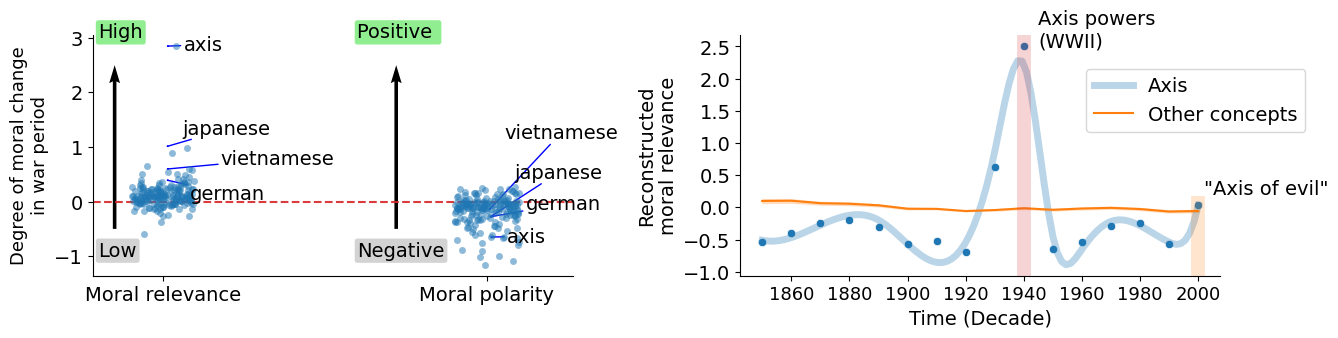

In [17]:
plotting_words = ["axis", "japanese", "german", "vietnamese"]
annotations = []
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=False)
fig.tight_layout()
plt.subplots_adjust(wspace=0.35)
ax = axes[0]
sns.stripplot(data=plot_df, x="variable", y="value", color="tab:blue", alpha=0.5, ax=ax)
ax.axhline(y=0, color="tab:red", alpha=0.9, ls="--")
ax.set_ylabel("Degree of moral change\nin war period", fontsize=13)
ax.set_xticklabels(["Moral relevance", "Moral polarity"], fontsize=14)
ax.set_xlabel("")
# ax.text(s = 'c)', x = -0.85, y = 3.5,fontsize =18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)

for w in plotting_words:

    w_rel = rel_compare_df.loc[rel_compare_df.word == w].iloc[0]
    w_pol = pol_compare_df.loc[pol_compare_df.word == w].iloc[0]
    annotations.append(ax.annotate(w, (0, w_rel["diff"]), color="black", size=14))
    annotations.append(ax.annotate(w, (1, w_pol["diff"]), color="black", size=14))


adjust_text(
    annotations,
    expand=(1.5, 1.5),
    arrowprops=dict(arrowstyle="->", color="blue"),
    ax=ax,
)

ax.quiver(-0.15, -0.5, 0, 3, angles="xy", scale_units="xy", scale=1)


ax.text(
    x=-0.2,
    y=-1,
    s="Low",
    color="Black",
    fontsize=14,
    bbox=dict(facecolor="lightgrey", edgecolor="lightgrey", boxstyle="round,pad=0.1"),
)


ax.text(
    x=-0.2,
    y=3,
    s="High",
    color="Black",
    fontsize=14,
    bbox=dict(facecolor="lightgreen", edgecolor="lightgreen", boxstyle="round,pad=0.1"),
)


ax.text(
    x=0.6,
    y=-1,
    s="Negative",
    color="Black",
    fontsize=14,
    bbox=dict(facecolor="lightgrey", edgecolor="lightgrey", boxstyle="round,pad=0.1"),
)


ax.text(
    x=0.6,
    y=3,
    s="Positive ",
    color="Black",
    fontsize=14,
    bbox=dict(facecolor="lightgreen", edgecolor="lightgreen", boxstyle="round,pad=0.1"),
)

ax.quiver(0.72, -0.5, 0, 3, angles="xy", scale_units="xy", scale=1)


ax = axes[1]
entity = "axis"
k = 3
war_years = (
    total_df.loc[(total_df.words == entity) & (total_df.property == "polarity")]
    .groupby(["year"])["War"]
    .apply(set)
    .to_dict()
)


sns.scatterplot(
    data=small_ts_df.loc[small_ts_df.words == entity].loc[
        small_ts_df.property == "previous_link"
    ],
    x="year",
    y="outputs_z",
    ax=ax,
)

x = (
    small_ts_df.loc[small_ts_df.words == entity]
    .loc[small_ts_df.property == "previous_link"]
    .year
)
y = (
    small_ts_df.loc[small_ts_df.words == entity]
    .loc[small_ts_df.property == "previous_link"]
    .outputs_z
)
spl = UnivariateSpline(x, y, k=k, s=0.35)
xs = np.linspace(x.min(), x.max(), 100)

ax.plot(xs, spl(xs), "tab:blue", lw=5, alpha=0.3, label=entity[0].upper() + entity[1:])
ax.text(x=1945, y=2.5, s="Axis powers\n(WWII)", fontsize=14)
ax.text(x=2002, y=0.2, s='"Axis of evil"', fontsize=14)
min_year = (
    small_ts_df.loc[small_ts_df.words == entity]
    .loc[small_ts_df.property == "previous_link"]
    .year.min()
)
sns.lineplot(
    data=all_df.loc[all_df.property == "previous_link"].loc[all_df.year >= min_year],
    x="year",
    y="outputs_z",
    label="Other concepts",
    ax=ax,
    color="tab:orange",
)

ax.legend(fontsize=14, bbox_to_anchor=(0.7, 0.9))
ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
ax.set_xlabel("Time (Decade)", fontsize=14)
ax.set_ylabel("Reconstructed\nmoral relevance", fontsize=14)
for year, war in war_years.items():
    ax.axvline(x=year, color="tab:red", linewidth=10, alpha=0.2, label=", ".join(war))
ax.axvline(
    x=2000, ymax=0.3, color="tab:orange", linewidth=10, alpha=0.2, label=", ".join(war),
)
sns.despine()

plt.savefig("notebooks/figs/coha_war_display3.png", dpi=400, bbox_inches="tight")
plt.savefig("notebooks/figs/coha_war_display3.pdf", dpi=400, bbox_inches="tight")

In [18]:
import pingouin

Now, we can compare moral relevance scores in war periods with peace periods

In [19]:
pingouin.ttest(
    rel_compare_df.war_score,
    rel_compare_df.n_war_score,
    paired=True,
    alternative="greater",
    r=0.7,
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,6.234583,182,greater,1.538716e-09,"[0.1, inf]",0.153328,5.788e+06,0.663345


Similarly, we can compare moral polarity scores in war periods with peace periods

In [20]:
pingouin.ttest(
    pol_compare_df.war_score,
    pol_compare_df.n_war_score,
    paired=True,
    alternative="less",
    r=0.7,
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-8.653282,182,less,1.298826e-15,"[-inf, -0.14]",0.166957,4.557e+12,0.727507


We can also compare sentiment scores in war periods with peace periods

In [21]:
pingouin.ttest(
    pol_compare_df.war_sentiment,
    pol_compare_df.n_war_sentiment,
    paired=True,
    alternative="less",
    r=0.7,
)  # War periods are indeed more sentimentally negative than non-war periods

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-6.990026,182,less,2.516334e-11,"[-inf, -0.02]",0.403104,3.081e+08,0.999924


## Let's compare moral association score for winner and loser sides of wars

In [22]:
from functools import reduce
from operator import concat

In [23]:
countries = list(df.Winner.unique()) + list(df.Loser.unique())
countries = set(countries)
countries = [x.split(",") for x in countries if not pd.isna(x)]
countries = set(reduce(concat, countries))
countries = [x.lower().strip() for x in countries]

In [24]:
country_mapping = {
    "argentine federalists": "argentina",
    "ikhwan brotherhood": "ikhwan",
    "chinese nationalists": "china",
    "united kingdom": "britain",
    "cambodian rebels": "cambodia",
    "warlord sun zuanfang": "zuanfang",
    "north korea": "korea",
    "chinese communists": "china",
    "indonesian rebels": "indonesia",
    "argentinian rebels": "argentina",
    "republic of korea": "korea",
    "ottoman empire": "ottoman",
    "garibaldi's rebels": "garibaldi",
    "argentinian government": "argentina",
    "spanish republicans": "spain",
    "senussi rebels": "senussi",
    "habsburg empire": "habsburg",
    "czechoslovak legion": "czechoslovakia",
    "polish rebels": "poland",
    "sudanese islamists": "sudan",
    "north vietnam": "vietnam",
    "south korea": "korea",
    "united states": "america",
    "united states of america": "america",
    "mexican conservatives": "mexico",
    "tekkes tribesmen": "tekkes",
    "white russians": "russia",
    "spanish nationalists": "spain",
    "mexican liberals": "mexico",
    "qing china": "china",
    "south vietnam": "vietnam",
    "chinese boxer rebels": "china",
    "arab rebels": "arab",
    "sudanese mahdists": "sudan",
    "indian rebels": "indian",
    "greek communists": "greece",
    "south vietnam": "vietnam",
    "confederate states of america": "confederate",
    "untied kingdom": "britain",
    "soviet union": "russia",
    "united states": "america",
    "buenos aries": "argentina",
}

In [25]:
total_df = pd.DataFrame()
list_rows = []
for i, row in df.iterrows():
    if pd.isna(row["Lehmann Zhukov Scale"]) or row["Lehmann Zhukov Scale"] < 3:
        continue

    winner = row["Winner"]
    loser = row["Loser"]
    if pd.isna(winner) or pd.isna(loser):
        continue

    winner = winner.split(",")
    winner = [x.lower().strip() for x in winner]
    winner = [country_mapping[x] if x in country_mapping else x for x in winner]

    loser = loser.split(",")
    loser = [x.lower().strip() for x in loser]
    loser = [country_mapping[x] if x in country_mapping else x for x in loser]
    if " ".join(winner) == " ".join(loser):
        continue
    scale = float(row["Lehmann Zhukov Scale"])

    small_ts_df = ts_df.loc[(ts_df.year == row["Decade"]) & (ts_df.words.isin(winner))]
    if len(small_ts_df) == 0:
        continue
    if row["War"][0] == "[":
        war = literal_eval(row["War"])
    else:
        war = row["War"]
    if isinstance(war, list):
        war = war[0]

    small_ts_df["War"] = war
    small_ts_df["Scale"] = scale
    small_ts_df["Winner"] = [True] * len(small_ts_df)

    winner_scores = small_ts_df.groupby("property").outputs_z.mean().to_dict()
    winner_sentiments = small_ts_df.groupby("property").sentiments.mean().to_dict()

    total_df = pd.concat((total_df, small_ts_df), ignore_index=True)

    small_ts_df = ts_df.loc[(ts_df.year == row["Decade"]) & (ts_df.words.isin(loser))]
    if len(small_ts_df) == 0:
        continue
    if row["War"][0] == "[":
        war = literal_eval(row["War"])
    else:
        war = row["War"]
    if isinstance(war, list):
        war = war[0]

    small_ts_df["War"] = war
    small_ts_df["Scale"] = scale
    small_ts_df["Winner"] = [False] * len(small_ts_df)
    loser_scores = small_ts_df.groupby("property").outputs_z.mean().to_dict()
    loser_sentiments = small_ts_df.groupby("property").sentiments.mean().to_dict()

    total_df = pd.concat((total_df, small_ts_df), ignore_index=True)
    list_rows.append(
        {
            "War": war,
            "Scale": scale,
            "Winner": ", ".join(winner),
            "Loser": ", ".join(loser),
            "Decade": row["Decade"],
            "loser_relevance": loser_scores["previous_link"],
            "loser_polarity": loser_scores["polarity"],
            "winner_relevance": winner_scores["previous_link"],
            "winner_polarity": winner_scores["polarity"],
            "loser_sentiment": loser_sentiments["previous_link"],
            "winner_sentiment": winner_sentiments["previous_link"],
        },
    )

In [26]:
compare_df = pd.DataFrame(list_rows)
compare_df = compare_df[
    [
        "Winner",
        "Loser",
        "Decade",
        "loser_relevance",
        "loser_polarity",
        "winner_relevance",
        "winner_polarity",
        "winner_sentiment",
        "loser_sentiment",
    ]
].drop_duplicates()

In [27]:
compare_df

,Winner,Loser,Decade,loser_relevance,loser_polarity,winner_relevance,winner_polarity,winner_sentiment,loser_sentiment
0,america,germany,1940.0,1.665519,0.028398,-0.067367,0.710717,0.115497,-0.004801
1,germany,russia,1910.0,-0.369616,0.161036,1.504815,0.394330,0.074315,0.093345
2,iran,iraq,1980.0,0.567560,-2.023405,0.399438,-0.058305,-0.074253,-0.167387
3,israel,egypt,1960.0,-0.483810,-0.120511,0.522086,-0.322204,0.049482,0.045501
4,italy,ethiopia,1930.0,0.035685,-1.730640,0.373930,-0.161130,0.081862,-0.005786
...,...,...,...,...,...,...,...,...,...
513,germany,poland,1940.0,0.331420,-0.308799,1.665519,0.028398,-0.004801,0.040080
514,japan,china,1890.0,0.703019,-0.237774,-0.375236,-0.270505,0.146710,0.166134
515,"britain, america, canada, france",germany,1940.0,1.665519,0.028398,-0.085836,0.282715,0.127506,-0.004801
521,south africa,germany,1910.0,1.504815,0.394330,0.336991,-0.362898,NaN,0.074315


In [28]:
pingouin.ttest(
    compare_df.winner_relevance,
    compare_df.loser_relevance,
    paired=True,
    alternative="less",
    r=0.7,
)  # Winner side is less morally relevant than loser side

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.82776,209,less,0.034506,"[-inf, -0.01]",0.197293,0.799,0.885884


In [29]:
pingouin.ttest(
    compare_df.winner_polarity,
    compare_df.loser_polarity,
    paired=True,
    alternative="greater",
    r=0.7,
)  # Winner side is more morally positive than loser side

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.844185,209,greater,0.002447,"[0.09, inf]",0.271667,7.811,0.988672


In [30]:
pingouin.ttest(
    compare_df.winner_sentiment,
    compare_df.loser_sentiment,
    paired=True,
    alternative="greater",
    r=0.7,
)  # Winner side is more sentimentally positive than loser side

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.990373,206,greater,0.023936,"[0.0, inf]",0.188015,1.086,0.853441


## Let's do a logistic regression analysis to compare the role of sentiments with morality on wining and losing sides

In [31]:
import statsmodels.formula.api as smf

In [32]:
copy_df = compare_df.copy(deep=True)
copy_df["side_1"] = copy_df["Winner"].copy()
copy_df["side_2"] = copy_df["Loser"].copy()

# now we want to see if the differences in sentiment, relevance, and polarity can predict which columns wins
half_1_df = copy_df.sample(frac=0.5, random_state=1)
half_2_df = copy_df.loc[~copy_df.index.isin(half_1_df.index)].reset_index(drop=True)


half_1_df["diff_sentiment"] = (
    half_1_df["winner_sentiment"] - half_1_df["loser_sentiment"]
)
half_1_df["diff_relevance"] = (
    half_1_df["winner_relevance"] - half_1_df["loser_relevance"]
)
half_1_df["diff_polarity"] = half_1_df["winner_polarity"] - half_1_df["loser_polarity"]
half_1_df["winner"] = [1] * len(half_1_df)

half_2_df["diff_sentiment"] = (
    -half_2_df["winner_sentiment"] + half_2_df["loser_sentiment"]
)
half_2_df["diff_relevance"] = (
    -half_2_df["winner_relevance"] + half_2_df["loser_relevance"]
)
half_2_df["diff_polarity"] = -half_2_df["winner_polarity"] + half_2_df["loser_polarity"]

half_2_df["winner"] = [0] * len(half_2_df)


logit_df = pd.concat((half_1_df, half_2_df), ignore_index=True)


model = smf.logit(
    formula="winner ~ diff_relevance + diff_polarity + diff_sentiment", data=logit_df,
)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.671360
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                  207
Model:                          Logit   Df Residuals:                      203
Method:                           MLE   Df Model:                            3
Date:                Thu, 08 May 2025   Pseudo R-squ.:                 0.03129
Time:                        08:08:43   Log-Likelihood:                -138.97
converged:                       True   LL-Null:                       -143.46
Covariance Type:            nonrobust   LLR p-value:                   0.02961
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0348      0.144     -0.242      0.809      -0.316       0.247
diff_relevance   

In [33]:
results.pred_table()

array([[70., 35.],
       [49., 53.]])